## Chinese to English: Machine Translation

Dataset Source: https://huggingface.co/datasets/GEM/wiki_lingua

#### Install Necessary Libraries

In [1]:
%pip install torch transformers datasets evaluate tensorboard
%pip install accelerate -U
%pip install sentencepiece sacrebleu rouge rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... 

#### Enter HuggingFace Access Token

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Import Necessary Libraries

In [3]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from transformers import DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, set_seed
from transformers import AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer

import datasets
from datasets import Dataset, DatasetDict, load_dataset

import evaluate

!git lfs install

Git LFS initialized.


#### Versions of Software & Libraries Used

In [4]:
library_len = 14
version_len = 12

print(f"+{'-' * (library_len + version_len + 5)}+")
print("|",
      "Library".rjust(library_len),
      "|",
      "Version".ljust(version_len),
      "|")

print(f"|{'*' * (library_len + version_len + 5)}|")

print("|",
      "Python".rjust(library_len),
      "|",
      sys.version[0:6].ljust(version_len),
      "|")

print("|",
      "NumPy".rjust(library_len),
      "|",
      np.__version__.ljust(version_len),
      "|")

print("|",
      "Pandas".rjust(library_len),
      "|",
      pd.__version__.ljust(version_len),
      "|")

print("|",
      "Torch".rjust(library_len),
      "|",
      torch.__version__.ljust(version_len),
      "|")

print("|",
      "Datasets".rjust(library_len),
      "|",
      datasets.__version__.ljust(version_len),
      "|")

print("|",
      "Transformer".rjust(library_len),
      "|",
      transformers.__version__.ljust(version_len),
      "|")

print(f"+{'-' * (library_len + version_len + 5)}+")

+-------------------------------+
|        Library | Version      |
|*******************************|
|         Python | 3.10.1       |
|          NumPy | 1.23.5       |
|         Pandas | 1.5.3        |
|          Torch | 2.0.1+cu118  |
|       Datasets | 2.14.4       |
|    Transformer | 4.31.0       |
+-------------------------------+


#### Ingest & Start Preprocessing Data

In [5]:
data = load_dataset("opus100", "en-zh")

data

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

#### Convert Dataset to Pandas DataFrame

In [6]:
data.set_format(type="pandas")

df = pd.concat(
    [
        data['train'][:],
        data['validation'][:],
        data['test'][:]
    ]
)

df = df.dropna()
df = df.reset_index(drop=True)

df

,translation
0,"{'en': 'Sixty-first session', 'zh': '第六十一届会议'}"
1,{'en': 'I took some medicine for my mu for my ...
2,{'en': 'It's a challenge. God is challenging y...
3,"{'en': 'Oh, baby.', 'zh': '.. 寶貝'}"
4,"{'en': '- Lucinda?', 'zh': '- 盧辛達？'}"
...,...
1003995,"{'en': 'Research associate', 'zh': '研究专员'}"
1003996,{'en': 'The LDCs must break out of the vicious...
1003997,{'en': 'a Information based on the statement o...
1003998,{'en': 'It will need to invest a lot more if t...


#### Split Translation Feature into Two Features (One For Each Language)

In [7]:
df['translation'] = df['translation'].astype(str)

# For English text
df['en'] = (df['translation']
            .apply(lambda x: x.split("',")[0])
            .apply(lambda x: x.split("'en':")[-1]))
df['en'] = (df['en']
            .replace(r'^["]', "", regex=True)
            .replace(r'^[\']', "", regex=True))
df['en'] = (df['en']
            .replace(r'["]$', "", regex=True)
            .replace(r'[\']$', "", regex=True))
df['en'] = df['en'].apply(lambda x: x.strip())

# For Chinese Text
df['zh'] = (df['translation']
            .apply(lambda x: x.split("'zh': ")[-1])
            .apply(lambda x: x.split("'}")[0]))
df['zh'] = (df['zh']
            .replace(r'^["]', "", regex=True)
            .replace(r'^[\']', "", regex=True))
df['zh'] = (df['zh']
            .replace(r'["]$', "", regex=True)
            .replace(r'[\']$', "", regex=True))
df['zh'] = df['zh'].apply(lambda x: x.strip())

df = df.drop(columns=['translation'])

df

,en,zh
0,'Sixty-first session,第六十一届会议
1,'I took some medicine for my mu for my mu my m...,减轻酸... 酸痛的药 减轻酸痛的药
2,"""It's a challenge. God is challenging you. He'...",上帝在挑战你，他说你是笨蛋
3,"'Oh, baby.",.. 寶貝
4,'- Lucinda?,- 盧辛達？
...,...,...
1003995,'Research associate,研究专员
1003996,'The LDCs must break out of the vicious circle...,最不发达国家必须脱离内战、不发达状态和边缘化三者组成的恶性循环，因此，官方发展援助是不可或缺的。
1003997,'a Information based on the statement of incom...,a 资料来源是2007年12月31日终了的2006-2007两年期收支报表。
1003998,'It will need to invest a lot more if the Suda...,但是，若要苏丹摆脱战争遗害，实现全面和平与发展，国际社会就需要大幅度增加投入。


#### Visual: Length of English Entries

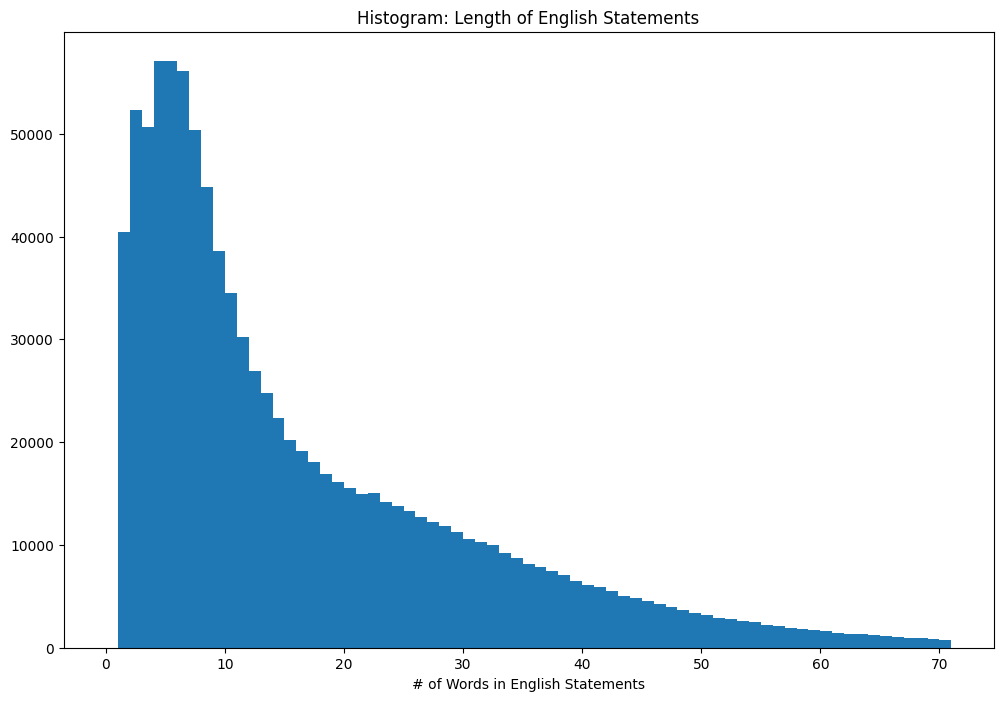

The Maximum length of English text is 70 words.


In [14]:
df['english_length'] = df['en'].str.split().str.len()

max_english_count = max(df['english_length'])

n_bin = max_english_count + 1

df.hist('english_length',
        grid=False,
        figsize=(12,8),
        range=(0,n_bin),
        bins=n_bin)
plt.title('Histogram: Length of English Statements')
plt.xlabel('# of Words in English Statements')
plt.show()

print(f"The Maximum length of English text is {max_english_count} words.")

#### Visual: Length of Chinese Entries

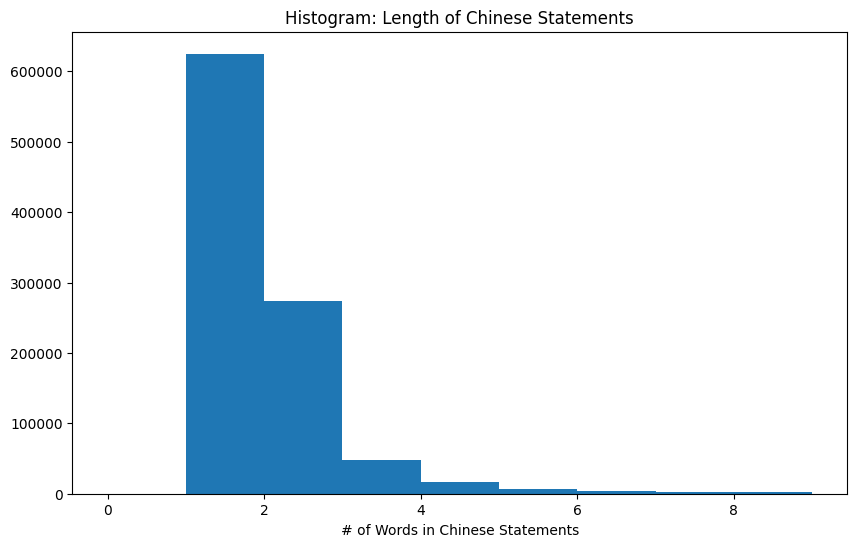

The Maximum length of Chinese text is 8 words.


In [15]:
df['chinese_length'] = df['zh'].str.split().str.len()

max_chinese_count = max(df['chinese_length'])

n_bin = max_chinese_count + 1

df.hist('chinese_length',
        grid=False,
        range=(0,n_bin),
        figsize=(10, 6),
        bins=n_bin)
plt.title('Histogram: Length of Chinese Statements')
plt.xlabel('# of Words in Chinese Statements')
plt.show()

print(f"The Maximum length of Chinese text is {max_chinese_count} words.")

#### Trim Dataset Size & Drop Unnecessary Features

In [17]:
most_input_words_en = 71
most_input_words_zh = 9

# Trim Chinese text
df = df[df['chinese_length'] < most_input_words_zh]

# Trim English text
df = df[df['english_length'] < most_input_words_en]

# reset the index
df = df.reset_index(drop=True)

# Remove columns that are no longer necessary
df = df.drop(columns=
  [
      'chinese_length',
      'english_length'
  ]
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980583 entries, 0 to 980582
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   en      980583 non-null  object
 1   zh      980583 non-null  object
dtypes: object(2)
memory usage: 15.0+ MB


#### Final Preprocessing

In [18]:
dataframe = df.iloc[:, [1, 0]]
all_data = dataframe.to_dict(orient='records')

dataframe = pd.Series(all_data)
dataframe = pd.DataFrame(dataframe)

dataframe = dataframe.rename(columns={ 0 : 'translation'})
dataframe.head()

,translation
0,"{'zh': '第六十一届会议', 'en': ''Sixty-first session'}"
1,"{'zh': '减轻酸... 酸痛的药 减轻酸痛的药', 'en': ''I took so..."
2,"{'zh': '上帝在挑战你，他说你是笨蛋', 'en': '""It's a challen..."
3,"{'zh': '.. 寶貝', 'en': ''Oh, baby.'}"
4,"{'zh': '- 盧辛達？', 'en': ''- Lucinda?'}"


#### Convert to Dataset Format & Split into Train/Test/Eval Datasets

In [19]:
dataset = Dataset.from_pandas(dataframe)

train_testEval = dataset.train_test_split(train_size=0.85)
test_eval = train_testEval['test'].train_test_split(train_size=0.80)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

print(f"\nTraining Dataset Example:\n{ds['train'][25]}")

Training Dataset Shape: (833495, 1)
Testing Dataset Shape: (117670, 1)
Evaluation Dataset Shape: (29418, 1)

Training Dataset Example:
{'translation': {'en': "'Six people get on. - Really?", 'zh': 'Think you got to, Johnny.'}}


#### Basic Values/Constants

In [20]:
set_seed = 42
NUM_OF_EPOCHS = 1

ACC_STEPS = 4
LEARNING_RATE = 2e-5

SOURCE_LANGUAGE = "zh"
TARGET_LANGUAGE = "en"

MODEL_CKPT = "Helsinki-NLP/opus-mt-zh-en"
MODEL_NAME = f"{MODEL_CKPT.split(f'/')[-1]}-Chinese_to_English"

REPORTS_TO = "tensorboard"
STRATEGY = "epoch"

#### Create Tokenizer

In [21]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


#### Create Preprocessing Function

In [22]:
def tokenizing_function(examples):
    inputs = [ex[SOURCE_LANGUAGE] for ex in examples['translation']]
    targets = [ex[TARGET_LANGUAGE] for ex in examples['translation']]
    model_inputs = tokenizer(inputs,
                             text_target=targets,
                             truncation=True)
    return model_inputs

#### Apply Preprocessing Function to Dataset

In [23]:
encoded_ds = ds.map(tokenizing_function,
                    batched=True)

print(encoded_ds['train'].shape)
print(encoded_ds['test'].shape)
print(encoded_ds['eval'].shape)

Map:   0%|          | 0/833495 [00:00<?, ? examples/s]

Map:   0%|          | 0/117670 [00:00<?, ? examples/s]

Map:   0%|          | 0/29418 [00:00<?, ? examples/s]

(833495, 4)
(117670, 4)
(29418, 4)


#### Instantiate Model

In [24]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CKPT)

#### Instantiate Data Collator

In [25]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                       model=MODEL_CKPT)

#### Create Function to Compute Metrics

In [26]:
bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds,
                                           skip_special_tokens=True)

    labels = np.where(labels != -100,
                      labels,
                      tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels,
                                            skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    bleu_results = bleu_metric.compute(predictions=decoded_preds,
                                       references=decoded_labels)
    rouge_results = rouge_metric.compute(predictions=decoded_preds,
                                         references=decoded_labels)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                       for pred in preds]

    return {"bleu" : bleu_results["score"],
            "rouge" : rouge_results,
            "Prediction Lengths": prediction_lens}

#### Instantiate Training Arguments

In [27]:
args = Seq2SeqTrainingArguments(output_dir=MODEL_NAME,
                                auto_find_batch_size=True,
                                gradient_accumulation_steps=ACC_STEPS,
                                eval_accumulation_steps=ACC_STEPS,
                                evaluation_strategy="no",
                                save_strategy=STRATEGY,
                                logging_strategy="steps",
                                logging_steps=250,
                                logging_first_step=True,
                                learning_rate=LEARNING_RATE,
                                report_to=REPORTS_TO,
                                weight_decay=0.01,
                                disable_tqdm=False,
                                num_train_epochs=NUM_OF_EPOCHS,
                                predict_with_generate=True,
                                fp16=True,
                                group_by_length=True,
                                hub_private_repo=True,
                                push_to_hub=True
                                )

#### Instantiate Trainer

In [28]:
trainer = Seq2SeqTrainer(model=model,
                         args=args,
                         train_dataset=encoded_ds['train'],
                         eval_dataset=encoded_ds['eval'],
                         tokenizer=tokenizer,
                         data_collator=data_collator,
                         compute_metrics=compute_metrics)

Cloning https://huggingface.co/DunnBC22/opus-mt-zh-en-Chinese_to_English into local empty directory.


#### Train Model

In [29]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,1.890300
250,1.370200
500,1.262400
750,1.248500
1000,1.225600
1250,1.204900
1500,1.206400
1750,1.216700
2000,1.214900
2250,1.198800


Adding files tracked by Git LFS: ['source.spm', 'target.spm']. This may take a bit of time if the files are large.


#### Push Model to HuggingFace Hub (My Profile!)

In [30]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/296M [00:00<?, ?B/s]

Upload file runs/Aug21_21-35-44_5da225ddecbc/events.out.tfevents.1692653833.5da225ddecbc.1178.0:   0%|        …

To https://huggingface.co/DunnBC22/opus-mt-zh-en-Chinese_to_English
   977af1c..3d7ed53  main -> main

   977af1c..3d7ed53  main -> main

To https://huggingface.co/DunnBC22/opus-mt-zh-en-Chinese_to_English
   3d7ed53..c89af91  main -> main

   3d7ed53..c89af91  main -> main



'https://huggingface.co/DunnBC22/opus-mt-zh-en-Chinese_to_English/commit/3d7ed53d57c9eecd722e2bb87eb4e829f039b08e'

#### Save & Log Model

In [31]:
trainer.save_model()
trainer.save_state()

#### Evaluate Model

In [32]:
metrics = trainer.evaluate()

Trainer is attempting to log a value of "{'rouge1': 0.6201063905016944, 'rouge2': 0.41983725092331425, 'rougeL': 0.5926860755041149, 'rougeLsum': 0.592735648754739}" of type <class 'dict'> for key "eval/rouge" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[14, 31, 22, 12, 31, 11, 39, 48, 6, 19, 16, 36, 35, 6, 23, 20, 21, 24, 20, 88, 23, 19, 21, 20, 13, 15, 17, 5, 19, 33, 4, 15, 16, 9, 46, 25, 30, 54, 17, 7, 20, 14, 34, 5, 28, 4, 18, 28, 24, 15, 19, 4, 18, 7, 18, 9, 8, 35, 6, 23, 4, 24, 21, 20, 72, 3, 13, 19, 6, 47, 9, 31, 36, 9, 31, 5, 38, 21, 56, 10, 17, 59, 21, 5, 13, 46, 5, 55, 19, 43, 7, 8, 22, 26, 25, 50, 26, 47, 52, 65, 22, 21, 20, 21, 22, 29, 35, 7, 21, 13, 36, 38, 45, 32, 10, 16, 20, 23, 10, 18, 51, 27, 6, 21, 10, 54, 14, 37, 53, 18, 3, 19, 48, 29, 49, 19, 32, 13, 53, 18, 38, 46, 44, 32, 12, 6, 39, 11, 52, 28, 24, 7, 9, 38, 32, 29, 5, 17, 35, 29, 21, 25, 17, 78, 50, 49, 70, 2

#### Print Metric Values

In [33]:
print(metrics)

{'eval_loss': 1.01129150390625, 'eval_bleu': 45.280808646960104, 'eval_rouge': {'rouge1': 0.6201063905016944, 'rouge2': 0.41983725092331425, 'rougeL': 0.5926860755041149, 'rougeLsum': 0.592735648754739}, 'eval_Prediction Lengths': [14, 31, 22, 12, 31, 11, 39, 48, 6, 19, 16, 36, 35, 6, 23, 20, 21, 24, 20, 88, 23, 19, 21, 20, 13, 15, 17, 5, 19, 33, 4, 15, 16, 9, 46, 25, 30, 54, 17, 7, 20, 14, 34, 5, 28, 4, 18, 28, 24, 15, 19, 4, 18, 7, 18, 9, 8, 35, 6, 23, 4, 24, 21, 20, 72, 3, 13, 19, 6, 47, 9, 31, 36, 9, 31, 5, 38, 21, 56, 10, 17, 59, 21, 5, 13, 46, 5, 55, 19, 43, 7, 8, 22, 26, 25, 50, 26, 47, 52, 65, 22, 21, 20, 21, 22, 29, 35, 7, 21, 13, 36, 38, 45, 32, 10, 16, 20, 23, 10, 18, 51, 27, 6, 21, 10, 54, 14, 37, 53, 18, 3, 19, 48, 29, 49, 19, 32, 13, 53, 18, 38, 46, 44, 32, 12, 6, 39, 11, 52, 28, 24, 7, 9, 38, 32, 29, 5, 17, 35, 29, 21, 25, 17, 78, 50, 49, 70, 28, 38, 45, 47, 32, 6, 10, 6, 27, 62, 79, 30, 65, 35, 20, 44, 35, 10, 67, 8, 9, 8, 9, 18, 15, 22, 17, 36, 6, 18, 10, 22, 8, 79, 57

### Notes & Other Takeaways From This Project
****
- Average Results!
- It would have been nice for the opportunity to fine tune this dataset for 4-6 epochs, but this result is nonetheless an excellent start.

****

#### Citations

- Model Checkpoint
    > https://huggingface.co/Helsinki-NLP/opus-mt-ko-en

- Metrics
    - Bleu
        > @INPROCEEDINGS{Papineni02bleu:a, author = {Kishore Papineni and Salim Roukos and Todd Ward and Wei-jing Zhu}, title = {BLEU: a Method for Automatic Evaluation of Machine Translation}, booktitle = {}, year = {2002}, pages = {311--318}}
        
        > @inproceedings{lin-och-2004-orange, title = "{ORANGE}: a Method for Evaluating Automatic Evaluation Metrics for Machine Translation", author = "Lin, Chin-Yew and Och, Franz Josef", booktitle = "{COLING} 2004: Proceedings of the 20th International Conference on Computational Linguistics", month = "aug 23{--}aug 27", year = "2004", address = "Geneva, Switzerland", publisher = "COLING", url = "https://www.aclweb.org/anthology/C04-1072", pages = "501--507",}
    
    - Rouge
        > @inproceedings{lin-2004-rouge, title = '{ROUGE}: A Package for Automatic Evaluation of Summaries', author = 'Lin, Chin-Yew', booktitle = 'Text Summarization Branches Out', month = jul, year = '2004', address = 'Barcelona, Spain', publisher = 'Association for Computational Linguistics', url = 'https://www.aclweb.org/anthology/W04-1013', pages = '74--81',}